In [2]:
# 라이브러리

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

In [3]:
# 데이터 로드

orders = pd.read_csv('orders.csv' )
order_products_train = pd.read_csv('order_products_train.csv')
order_products_prior = pd.read_csv('order_products_prior.csv')
products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
train = pd.read_csv('train.csv')

In [4]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [5]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [6]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [7]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [8]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [9]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


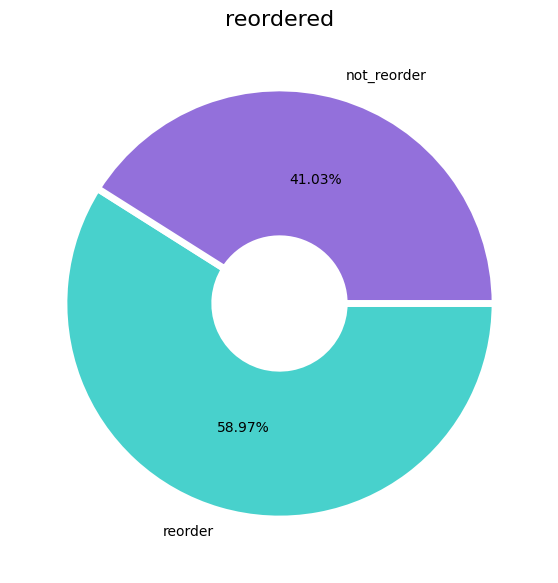

In [10]:
colors = ['mediumturquoise', 'mediumpurple']
plt.figure(figsize=(7,7))

labels = ("reorder", "not_reorder")

wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

plt.pie(order_products_prior['reordered'].value_counts(), 
        autopct='%1.2f%%', 
        labels = labels, 
        counterclock=False, 
        colors=colors, 
        wedgeprops=wedgeprops)

plt.title("reordered", fontsize=16)

plt.show()

# 59%가 재주문

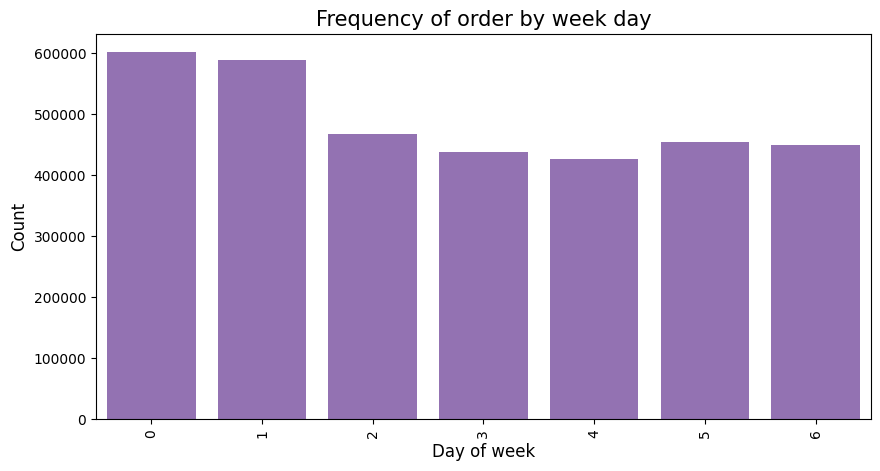

In [11]:
plt.figure(figsize=(10,5))
sns.countplot(x="order_dow", data=orders, color=color[4])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

# 어떤 값이 어떤 요일을 나타내는지에 대한 정보는 없지만 주말이라고 가정할 수 있음
# 주말(즉, 토요일과 일요일)에 주문 수가 증가하고 수요일에 가장 적은 수의 주문이 완료되었음을 알 수 있음

# 외국은 일월화수목금토로 살기 때문에 일요일 월요일에 주문 수가 증가한다는 것을 알 수 있음 

In [12]:
# 데이터 재구성
# 카테고리로 (text 값 유한한 리스트를 표현할 때 사용)

aisles['aisle'] = aisles['aisle'].astype('category')

departments['department'] = departments['department'].astype('category')

orders['eval_set'] = orders['eval_set'].astype('category')

products['product_name'] = products['product_name'].astype('category')

In [13]:
# order + order_products_prior (이너조인)

op = orders.merge(order_products_prior, on='order_id', how='inner')
op.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


In [14]:
# 사용자 예측 변수 (고객 당 총 주문 수)
# user (user_id로 그룹 만들고 order_number 높은 순 / u_total_orders로 넣어)

user = op.groupby('user_id')['order_number'].max().to_frame('u_total_orders')
user.head()

,u_total_orders
user_id,
1,10
2,14
3,12
4,5
5,4


In [15]:
# user_id 인덱스 --> 열로 바꿈

user = user.reset_index()
user.head()

,user_id,u_total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [16]:
# 고객이 제품을 재주문한 빈도
# u_reorder (user_id로 그룹 만들고 reordered 평균 / u_reordered_ratio로 넣어)

u_reorder = op.groupby('user_id')['reordered'].mean().to_frame('u_reordered_ratio')
u_reorder = u_reorder.reset_index()
u_reorder.head()

,user_id,u_reordered_ratio
0,1,0.694915
1,2,0.476923
2,3,0.625000
3,4,0.055556
4,5,0.378378


In [17]:
# user 랑 u_reorder랑 머지

user = user.merge(u_reorder, on='user_id', how='left')

#del u_reorder
#gc.collect()

user.head()

,user_id,u_total_orders,u_reordered_ratio
0,1,10,0.694915
1,2,14,0.476923
2,3,12,0.625000
3,4,5,0.055556
4,5,4,0.378378


In [18]:
# 각 제품에 대한 총 구매 수
# u_reorder (product_id로 그룹 만들고 order_id 카운트 / p_total_purchases로 넣어)
prd = op.groupby('product_id')['order_id'].count().to_frame('p_total_purchases')
prd.head()

,p_total_purchases
product_id,
1,1852
2,90
3,277
4,329
5,15


In [19]:
# product_id 인덱스 --> 열로 바꿈

prd = prd.reset_index()
prd.head()

,product_id,p_total_purchases
0,1,1852
1,2,90
2,3,277
3,4,329
4,5,15


In [20]:
# .product_id로 그룹 만들고 .filter() 사용해서 40개 이상의 행이 있는 그룹만 유지  ( <-- 구매 횟수 40회 미만 제거)
# x on lambda 함수는 각 그룹을 나타내는 임시 변수
# DataFrame의 shape[0]은 행 수를 반환

p_reorder = op.groupby('product_id').filter(lambda x: x.shape[0] >40)
p_reorder.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


In [21]:
# 그룹 제품, 재주문 평균 계산
# p_reorder (product_id로 그룹 만들고 reordered 평균 / p_reorder_ratio로 넣어)

p_reorder = p_reorder.groupby('product_id')['reordered'].mean().to_frame('p_reorder_ratio')
p_reorder = p_reorder.reset_index()
p_reorder.head()

,product_id,p_reorder_ratio
0,1,0.613391
1,2,0.133333
2,3,0.732852
3,4,0.446809
4,8,0.503030


In [22]:
# prd + p_reorder 조인

prd = prd.merge(p_reorder, on='product_id', how='left')
prd.head()

,product_id,p_total_purchases,p_reorder_ratio
0,1,1852,0.613391
1,2,90,0.133333
2,3,277,0.732852
3,4,329,0.446809
4,5,15,NaN


In [23]:
# NaN값 0으로

prd['p_reorder_ratio'] = prd['p_reorder_ratio'].fillna(value=0)
prd.head()

,product_id,p_total_purchases,p_reorder_ratio
0,1,1852,0.613391
1,2,90,0.133333
2,3,277,0.732852
3,4,329,0.446809
4,5,15,0.000000


In [24]:
# 사용자가 제품을 구매한 횟수
# p_reorder ('user_id', 'product_id'로 그룹 만들고 'order_id' 카운트 / uxp_total_bought로 넣어)
 
uxp = op.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('uxp_total_bought')
uxp.head()

uxp_total_bought
user_id product_id                  
1       196                       10
        10258                      9
        10326                      1
        12427                     10
        13032                      3

In [25]:
# user_id & product_id 인덱스 --> 열로 바꿈

uxp = uxp.reset_index()
uxp.head()

,user_id,product_id,uxp_total_bought
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [26]:
times = op.groupby(['user_id', 'product_id'])[['order_id']].count()
times.columns = ['Times_Bought_N']
times.head()

Times_Bought_N
user_id product_id                
1       196                     10
        10258                    9
        10326                    1
        12427                   10
        13032                    3

In [27]:
total_orders = op.groupby('user_id')['order_number'].max().to_frame('total_orders')
total_orders.head()

,total_orders
user_id,
1,10
2,14
3,12
4,5
5,4


In [28]:
first_order_no = op.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number')
first_order_no  = first_order_no.reset_index()  # 인덱스 --> 열로 바꿈
first_order_no.head()

,user_id,product_id,first_order_number
0,1,196,1
1,1,10258,2
2,1,10326,5
3,1,12427,1
4,1,13032,2


In [29]:
# span (total_orders + first_order_no 머지)
span = pd.merge(total_orders, first_order_no, on='user_id', how='right')
span.head()

,user_id,total_orders,product_id,first_order_number
0,1,10,196,1
1,1,10,10258,2
2,1,10,10326,5
3,1,10,12427,1
4,1,10,13032,2


In [30]:
span['Order_Range_D'] = span.total_orders - span.first_order_number + 1  # (+1은 제품 구매한 첫 번째 주문 차이에 포함)
span.head()

,user_id,total_orders,product_id,first_order_number,Order_Range_D
0,1,10,196,1,10
1,1,10,10258,2,9
2,1,10,10326,5,6
3,1,10,12427,1,10
4,1,10,13032,2,9


In [31]:
# times, span 머지

uxp_ratio = pd.merge(times, span, on=['user_id', 'product_id'], how='left')
uxp_ratio.head()

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D
0,1,196,10,10,1,10
1,1,10258,9,10,2,9
2,1,10326,1,10,5,6
3,1,12427,10,10,1,10
4,1,13032,3,10,2,9


In [32]:
# 비율 (사용자 및 제품별)

uxp_ratio['uxp_reorder_ratio'] = uxp_ratio.Times_Bought_N / uxp_ratio.Order_Range_D
uxp_ratio.head()

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D,uxp_reorder_ratio
0,1,196,10,10,1,10,1.000000
1,1,10258,9,10,2,9,1.000000
2,1,10326,1,10,5,6,0.166667
3,1,12427,10,10,1,10,1.000000
4,1,13032,3,10,2,9,0.333333


In [33]:
# user_id, product_id, uxp_reorder_ratio만 남겨

uxp_ratio = uxp_ratio.drop(['Times_Bought_N', 'total_orders', 'first_order_number', 'Order_Range_D'], axis=1)
uxp_ratio.head()

,user_id,product_id,uxp_reorder_ratio
0,1,196,1.000000
1,1,10258,1.000000
2,1,10326,0.166667
3,1,12427,1.000000
4,1,13032,0.333333


In [34]:
uxp = uxp.merge(uxp_ratio, on=['user_id', 'product_id'], how='left')

#del uxp_ratio
uxp.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio
0,1,196,10,1.000000
1,1,10258,9,1.000000
2,1,10326,1,0.166667
3,1,12427,10,1.000000
4,1,13032,3,0.333333


In [35]:
# 고객 1 주문

op[op.user_id==1].head(45)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0
5,2398795,1,prior,2,3,7,15.0,196,1,1
6,2398795,1,prior,2,3,7,15.0,10258,2,0
7,2398795,1,prior,2,3,7,15.0,12427,3,1
8,2398795,1,prior,2,3,7,15.0,13176,4,0
9,2398795,1,prior,2,3,7,15.0,26088,5,1


In [36]:
# 사용자가 제품을 구매한 횟수
# p_reorder ('user_id'로 그룹 만들고 order_number 의 가장 높은 수를 가져온 후 빼기(-) op.order_number를 사용하여 각 행의 order_number를 불러와

op['order_number_back'] = op.groupby('user_id')['order_number'].transform(max) - op.order_number +1 
op.head(15)  # 15개만 보자

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,order_number_back
0,2539329,1,prior,1,2,8,NaN,196,1,0,10
1,2539329,1,prior,1,2,8,NaN,14084,2,0,10
2,2539329,1,prior,1,2,8,NaN,12427,3,0,10
3,2539329,1,prior,1,2,8,NaN,26088,4,0,10
4,2539329,1,prior,1,2,8,NaN,26405,5,0,10
5,2398795,1,prior,2,3,7,15.0,196,1,1,9
6,2398795,1,prior,2,3,7,15.0,10258,2,0,9
7,2398795,1,prior,2,3,7,15.0,12427,3,1,9
8,2398795,1,prior,2,3,7,15.0,13176,4,0,9
9,2398795,1,prior,2,3,7,15.0,26088,5,1,9


In [37]:
# 각 고객의 마지막 5개 주문만 유지

op5 = op[op.order_number_back <= 5]
op5.head(15)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,order_number_back
29,3367565,1,prior,6,2,7,19.0,196,1,1,5
30,3367565,1,prior,6,2,7,19.0,12427,2,1,5
31,3367565,1,prior,6,2,7,19.0,10258,3,1,5
32,3367565,1,prior,6,2,7,19.0,25133,4,1,5
33,550135,1,prior,7,1,9,20.0,196,1,1,4
34,550135,1,prior,7,1,9,20.0,10258,2,1,4
35,550135,1,prior,7,1,9,20.0,12427,3,1,4
36,550135,1,prior,7,1,9,20.0,25133,4,1,4
37,550135,1,prior,7,1,9,20.0,13032,5,1,4
38,3108588,1,prior,8,1,14,14.0,12427,1,1,3


In [38]:
# 각 사용자에 대한 마지막 5개의 주문을 유지한 후 user_id, product_id로 묶어 
# .count( ) 사용해서 각 고객이 제품을 구매한 횟수

last_five = op5.groupby(['user_id','product_id'])[['order_id']].count()
last_five.columns = ['times_last5']
last_five.head(10)

times_last5
user_id product_id             
1       196                   5
        10258                 5
        12427                 5
        13032                 2
        25133                 5
        35951                 1
        38928                 1
        39657                 1
        46149                 3
        49235                 2

In [39]:
# uxp + last_five 머지

uxp = uxp.merge(last_five, on=['user_id', 'product_id'], how='left')
uxp.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5
0,1,196,10,1.000000,5.0
1,1,10258,9,1.000000,5.0
2,1,10326,1,0.166667,NaN
3,1,12427,10,1.000000,5.0
4,1,13032,3,0.333333,2.0


In [40]:
# NaN값 0으로

uxp = uxp.fillna(0)
uxp.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5
0,1,196,10,1.000000,5.0
1,1,10258,9,1.000000,5.0
2,1,10326,1,0.166667,0.0
3,1,12427,10,1.000000,5.0
4,1,13032,3,0.333333,2.0


In [41]:
# uxp + user 머지머지

data = uxp.merge(user, on='user_id', how='left')
data.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5,u_total_orders,u_reordered_ratio
0,1,196,10,1.000000,5.0,10,0.694915
1,1,10258,9,1.000000,5.0,10,0.694915
2,1,10326,1,0.166667,0.0,10,0.694915
3,1,12427,10,1.000000,5.0,10,0.694915
4,1,13032,3,0.333333,2.0,10,0.694915


In [42]:
# data + prd 머지

data = data.merge(prd, on='product_id', how='left')
data.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,1,196,10,1.000000,5.0,10,0.694915,35791,0.776480
1,1,10258,9,1.000000,5.0,10,0.694915,1946,0.713772
2,1,10326,1,0.166667,0.0,10,0.694915,5526,0.652009
3,1,12427,10,1.000000,5.0,10,0.694915,6476,0.740735
4,1,13032,3,0.333333,2.0,10,0.694915,3751,0.657158


In [43]:
# 두 단계에서 모든 고객의 향후 주문만 유지: 학습 및 테스트

orders_future = orders[((orders.eval_set=='train') | (orders.eval_set=='test'))]
orders_future = orders_future[ ['user_id', 'eval_set', 'order_id'] ]
orders_future.head(10)

,user_id,eval_set,order_id
10,1,train,1187899
25,2,train,1492625
38,3,test,2774568
44,4,test,329954
49,5,train,2196797
53,6,test,1528013
74,7,train,525192
78,8,train,880375
82,9,train,1094988
88,10,train,1822501


In [44]:
# data + orders_future 머지

data = data.merge(orders_future, on='user_id', how='left')
data.head(10)

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id
0,1,196,10,1.000000,5.0,10,0.694915,35791,0.776480,train,1187899
1,1,10258,9,1.000000,5.0,10,0.694915,1946,0.713772,train,1187899
2,1,10326,1,0.166667,0.0,10,0.694915,5526,0.652009,train,1187899
3,1,12427,10,1.000000,5.0,10,0.694915,6476,0.740735,train,1187899
4,1,13032,3,0.333333,2.0,10,0.694915,3751,0.657158,train,1187899
5,1,13176,2,0.222222,0.0,10,0.694915,379450,0.832555,train,1187899
6,1,14084,1,0.100000,0.0,10,0.694915,15935,0.810982,train,1187899
7,1,17122,1,0.166667,0.0,10,0.694915,13880,0.675576,train,1187899
8,1,25133,8,1.000000,5.0,10,0.694915,6196,0.740155,train,1187899
9,1,26088,2,0.200000,0.0,10,0.694915,2523,0.539041,train,1187899


In [45]:
# eval_set에서 train 뽑기

data_train = data[data.eval_set=='train']
data_train.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id
0,1,196,10,1.000000,5.0,10,0.694915,35791,0.776480,train,1187899
1,1,10258,9,1.000000,5.0,10,0.694915,1946,0.713772,train,1187899
2,1,10326,1,0.166667,0.0,10,0.694915,5526,0.652009,train,1187899
3,1,12427,10,1.000000,5.0,10,0.694915,6476,0.740735,train,1187899
4,1,13032,3,0.333333,2.0,10,0.694915,3751,0.657158,train,1187899


In [46]:
# train이니까 order_product_train 머지 (csv 파일)

data_train = data_train.merge(order_products_train[['product_id','order_id', 'reordered']], on=['product_id','order_id'], how='left' )
data_train.head(15)

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id,reordered
0,1,196,10,1.000000,5.0,10,0.694915,35791,0.776480,train,1187899,1.0
1,1,10258,9,1.000000,5.0,10,0.694915,1946,0.713772,train,1187899,1.0
2,1,10326,1,0.166667,0.0,10,0.694915,5526,0.652009,train,1187899,NaN
3,1,12427,10,1.000000,5.0,10,0.694915,6476,0.740735,train,1187899,NaN
4,1,13032,3,0.333333,2.0,10,0.694915,3751,0.657158,train,1187899,1.0
5,1,13176,2,0.222222,0.0,10,0.694915,379450,0.832555,train,1187899,NaN
6,1,14084,1,0.100000,0.0,10,0.694915,15935,0.810982,train,1187899,NaN
7,1,17122,1,0.166667,0.0,10,0.694915,13880,0.675576,train,1187899,NaN
8,1,25133,8,1.000000,5.0,10,0.694915,6196,0.740155,train,1187899,1.0
9,1,26088,2,0.200000,0.0,10,0.694915,2523,0.539041,train,1187899,1.0


In [47]:
# NaN값 0 처리

data_train['reordered'] = data_train['reordered'].fillna(0)
data_train.head(15)

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id,reordered
0,1,196,10,1.000000,5.0,10,0.694915,35791,0.776480,train,1187899,1.0
1,1,10258,9,1.000000,5.0,10,0.694915,1946,0.713772,train,1187899,1.0
2,1,10326,1,0.166667,0.0,10,0.694915,5526,0.652009,train,1187899,0.0
3,1,12427,10,1.000000,5.0,10,0.694915,6476,0.740735,train,1187899,0.0
4,1,13032,3,0.333333,2.0,10,0.694915,3751,0.657158,train,1187899,1.0
5,1,13176,2,0.222222,0.0,10,0.694915,379450,0.832555,train,1187899,0.0
6,1,14084,1,0.100000,0.0,10,0.694915,15935,0.810982,train,1187899,0.0
7,1,17122,1,0.166667,0.0,10,0.694915,13880,0.675576,train,1187899,0.0
8,1,25133,8,1.000000,5.0,10,0.694915,6196,0.740155,train,1187899,1.0
9,1,26088,2,0.200000,0.0,10,0.694915,2523,0.539041,train,1187899,1.0


In [48]:
# 인덱스 바꾸기

data_train = data_train.set_index(['user_id', 'product_id'])
data_train.head(15)

uxp_total_bought  uxp_reorder_ratio  times_last5  \
user_id product_id                                                     
1       196                       10           1.000000          5.0   
        10258                      9           1.000000          5.0   
        10326                      1           0.166667          0.0   
        12427                     10           1.000000          5.0   
        13032                      3           0.333333          2.0   
        13176                      2           0.222222          0.0   
        14084                      1           0.100000          0.0   
        17122                      1           0.166667          0.0   
        25133                      8           1.000000          5.0   
        26088                      2           0.200000          0.0   
        26405                      2           0.200000          0.0   
        30450                      1           0.125000          0.0   
        35951                      1           1.000000          1.0   
        38928                      1           1.000000          1.0   
        39657                      1           1.000000          1.0   

                    u_total_orders  u_reordered_ratio  p_total_purchases  \
user_id product_id                                                         
1       196                     10           0.694915              35791   
        10258                   10           0.694915               1946   
        10326                   10           0.694915               5526   
        12427                   10           0.694915               6476   
        13032                   10           0.694915               3751   
        13176                   10           0.694915             379450   
        14084                   10           0.694915              15935   
        17122                   10           0.694915              13880   
        25133                   10           0.694915               6196   
        26088                   10           0.694915               2523   
        26405                   10           0.694915               1214   
        30450                   10           0.694915              21490   
        35951                   10           0.694915              57895   
        38928                   10           0.694915              13238   
        39657                   10           0.694915               5019   

                    p_reorder_ratio eval_set  order_id  reordered  
user_id product_id                                                 
1       196                0.776480    train   1187899        1.0  
        10258              0.713772    train   1187899        1.0  
        10326              0.652009    train   1187899        0.0  
        12427              0.740735    train   1187899        0.0  
        13032              0.657158    train   1187899        1.0  
        13176              0.832555    train   1187899        0.0  
        14084              0.810982    train   1187899        0.0  
        17122              0.675576    train   1187899        0.0  
        25133              0.740155    train   1187899        1.0  
        26088              0.539041    train   1187899        1.0  
        26405              0.441516    train   1187899        1.0  
        30450              0.566682    train   1187899        0.0  
        35951              0.757837    train   1187899        0.0  
        38928              0.827769    train   1187899        1.0  
        39657              0.766288    train   1187899        1.0

In [49]:
# 예측 변수가 아닌 변수를 제거 ('eval_set', 'order_id')

data_train = data_train.drop(['eval_set', 'order_id'], axis=1)
data_train.head(15)

uxp_total_bought  uxp_reorder_ratio  times_last5  \
user_id product_id                                                     
1       196                       10           1.000000          5.0   
        10258                      9           1.000000          5.0   
        10326                      1           0.166667          0.0   
        12427                     10           1.000000          5.0   
        13032                      3           0.333333          2.0   
        13176                      2           0.222222          0.0   
        14084                      1           0.100000          0.0   
        17122                      1           0.166667          0.0   
        25133                      8           1.000000          5.0   
        26088                      2           0.200000          0.0   
        26405                      2           0.200000          0.0   
        30450                      1           0.125000          0.0   
        35951                      1           1.000000          1.0   
        38928                      1           1.000000          1.0   
        39657                      1           1.000000          1.0   

                    u_total_orders  u_reordered_ratio  p_total_purchases  \
user_id product_id                                                         
1       196                     10           0.694915              35791   
        10258                   10           0.694915               1946   
        10326                   10           0.694915               5526   
        12427                   10           0.694915               6476   
        13032                   10           0.694915               3751   
        13176                   10           0.694915             379450   
        14084                   10           0.694915              15935   
        17122                   10           0.694915              13880   
        25133                   10           0.694915               6196   
        26088                   10           0.694915               2523   
        26405                   10           0.694915               1214   
        30450                   10           0.694915              21490   
        35951                   10           0.694915              57895   
        38928                   10           0.694915              13238   
        39657                   10           0.694915               5019   

                    p_reorder_ratio  reordered  
user_id product_id                              
1       196                0.776480        1.0  
        10258              0.713772        1.0  
        10326              0.652009        0.0  
        12427              0.740735        0.0  
        13032              0.657158        1.0  
        13176              0.832555        0.0  
        14084              0.810982        0.0  
        17122              0.675576        0.0  
        25133              0.740155        1.0  
        26088              0.539041        1.0  
        26405              0.441516        1.0  
        30450              0.566682        0.0  
        35951              0.757837        0.0  
        38928              0.827769        1.0  
        39657              0.766288        1.0

In [50]:
# eval_set에서 테스트 데이터 뽑음

data_test = data[data.eval_set=='test']
data_test.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id
120,3,248,1,0.090909,0.0,12,0.625,6371,0.400251,test,2774568
121,3,1005,1,0.333333,1.0,12,0.625,463,0.440605,test,2774568
122,3,1819,3,0.333333,0.0,12,0.625,2424,0.492162,test,2774568
123,3,7503,1,0.100000,0.0,12,0.625,12474,0.553551,test,2774568
124,3,8021,1,0.090909,0.0,12,0.625,27864,0.591157,test,2774568


In [51]:
# 인덱스 바꾸기

data_test = data_test.set_index(['user_id', 'product_id'])
data_test.head()

uxp_total_bought  uxp_reorder_ratio  times_last5  \
user_id product_id                                                     
3       248                        1           0.090909          0.0   
        1005                       1           0.333333          1.0   
        1819                       3           0.333333          0.0   
        7503                       1           0.100000          0.0   
        8021                       1           0.090909          0.0   

                    u_total_orders  u_reordered_ratio  p_total_purchases  \
user_id product_id                                                         
3       248                     12              0.625               6371   
        1005                    12              0.625                463   
        1819                    12              0.625               2424   
        7503                    12              0.625              12474   
        8021                    12              0.625              27864   

                    p_reorder_ratio eval_set  order_id  
user_id product_id                                      
3       248                0.400251     test   2774568  
        1005               0.440605     test   2774568  
        1819               0.492162     test   2774568  
        7503               0.553551     test   2774568  
        8021               0.591157     test   2774568

In [52]:
# 예측 변수가 아닌 변수를 제거 ('eval_set', 'order_id')

data_test = data_test.drop(['eval_set','order_id'], axis=1)
data_test.head(15)

uxp_total_bought  uxp_reorder_ratio  times_last5  \
user_id product_id                                                     
3       248                        1           0.090909          0.0   
        1005                       1           0.333333          1.0   
        1819                       3           0.333333          0.0   
        7503                       1           0.100000          0.0   
        8021                       1           0.090909          0.0   
        9387                       5           0.416667          0.0   
        12845                      1           0.111111          0.0   
        14992                      2           0.285714          0.0   
        15143                      1           0.083333          0.0   
        16797                      3           0.250000          1.0   
        16965                      2           0.222222          0.0   
        17668                      5           0.416667          2.0   
        18370                      1           0.125000          0.0   
        18599                      4           0.666667          3.0   
        21137                      1           0.090909          0.0   

                    u_total_orders  u_reordered_ratio  p_total_purchases  \
user_id product_id                                                         
3       248                     12              0.625               6371   
        1005                    12              0.625                463   
        1819                    12              0.625               2424   
        7503                    12              0.625              12474   
        8021                    12              0.625              27864   
        9387                    12              0.625              36187   
        12845                   12              0.625              10027   
        14992                   12              0.625              29069   
        15143                   12              0.625               3447   
        16797                   12              0.625             142951   
        16965                   12              0.625              13273   
        17668                   12              0.625               2110   
        18370                   12              0.625              18449   
        18599                   12              0.625               6204   
        21137                   12              0.625             264683   

                    p_reorder_ratio  
user_id product_id                   
3       248                0.400251  
        1005               0.440605  
        1819               0.492162  
        7503               0.553551  
        8021               0.591157  
        9387               0.650427  
        12845              0.362920  
        14992              0.582820  
        15143              0.492022  
        16797              0.698155  
        16965              0.538386  
        17668              0.578199  
        18370              0.603827  
        18599              0.416022  
        21137              0.777704

In [53]:
df = pd.merge(data_train, data_test)

In [54]:
from sklearn.model_selection import train_test_split
X = df.drop('reordered', axis=1)
y = df['reordered']

# 테스트 사이즈 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
# 기준 모델

from xgboost import XGBClassifier

model = XGBClassifier() 
model.fit(X_train,y_train)
print('Train accuracy score: ' + str(model.score(X_train, y_train))) #recall
print('Test accuracy score:' + str(model.score(X_test, y_test))) #recall

Train accuracy score: 0.8303568053823185
Test accuracy score:0.8217107003817515


In [56]:
from sklearn.pipeline import make_pipeline

xgb_pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(
        objective = "binary:logistic",
        eval_metric = "error",
        n_estimators = 200,
        random_state = 42,
        n_jobs = -1,
        learning_rate = 0.1,
        class_weight = "balanced",
        use_label_encoder = False,
        scale_pos_weight = y_train.value_counts()[0]/y_train.value_counts()[1] # sum(negative instances) / sum(positive instances)   # y_train.value_counts()[0]/y_train.value_counts()[1]
    ),
)
xgb_pipe.fit(X_train, y_train)
print("검증 정확도", xgb_pipe.score(X_test, y_test))

[18:00:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


검증 정확도 0.7006841289639792


In [57]:
from scipy.stats.distributions import uniform

params = {
    "simpleimputer__strategy": ["median", "mean"],
    "xgbclassifier__max_depth": [2, 4, 8],
    "xgbclassifier__min_child_weight": [4, 8, 10],
    "xgbclassifier__colsample_bytree": uniform(
        loc=0.5, scale=0.5
    ),  # 0.5 ~ 1 사이의 uniform 분포로 범위를 지정해 줍니다.
}

> RandomSearchCV - XGBoost (0 1 분류문제)

In [58]:
from sklearn.model_selection import RandomizedSearchCV

randomized_search = RandomizedSearchCV(
    xgb_pipe,
    param_distributions = params,
    scoring="roc_auc",
    n_iter=10,
    cv=3,
    verbose=3,
    random_state=42,
)
randomized_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[18:00:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV 1/3] END simpleimputer__strategy=median, xgbclassifier__colsample_bytree=0.8982714934301164, xgbclassifier__max_depth=8, xgbclassifier__min_child_weight=10;, score=0.744 total time=   2.4s
[18:00:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually be

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=[],
                                                             mapping=[])),
                                             ('simpleimputer', SimpleImputer()),
                                             ('xgbclassifier',
                                              XGBClassifier(base_score=0.5,
                                                            booster='gbtree',
                                                            callbacks=None,
                                                            class_weight='balanced',
                                                            colsample_bylevel=1,
                                                            colsample_bynode=1,
                                                            colsample_bytree=1,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,...
                                                            predictor='auto',
                                                            random_state=42,
                                                            reg_alpha=0, ...))]),
                   param_distributions={'simpleimputer__strategy': ['median',
                                                                    'mean'],
                                        'xgbclassifier__colsample_bytree': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001D001C02550>,
                                        'xgbclassifier__max_depth': [2, 4, 8],
                                        'xgbclassifier__min_child_weight': [4,
                                                                            8,
                                                                            10]},
                   random_state=42, scoring='roc_auc', verbose=3)

In [59]:
print("최적 하이퍼파라미터: ", randomized_search.best_params_)
print("최적 AUC: ", randomized_search.best_score_)

최적 하이퍼파라미터:  {'simpleimputer__strategy': 'median', 'xgbclassifier__colsample_bytree': 0.8982714934301164, 'xgbclassifier__max_depth': 8, 'xgbclassifier__min_child_weight': 10}
최적 AUC:  0.7423072591330985


In [60]:
from xgboost import XGBClassifier

xgb_pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy= 'median'),
    XGBClassifier(
        objective = "binary:logistic",
        eval_metric = "error",
        n_estimators = 200,
        random_state = 42,
        n_jobs = -1,
        learning_rate = 0.1,
        use_label_encoder = False,
        colsample_bytree= 0.8982714934301164,
        max_depth= 8,
        min_child_weight= 10,
        scale_pos_weight = y_train.value_counts()[0]/y_train.value_counts()[1] # sum(negative instances) / sum(positive instances)   # y_train.value_counts()[0]/y_train.value_counts()[1]
    ),
)
xgb_pipe.fit(X_train, y_train)
print("검증 정확도", xgb_pipe.score(X_test, y_test))

검증 정확도 0.7088861170956646


> XGBoost 정확도 0.71 !!!!!! (최적 하이퍼파라미터 적용)

              precision    recall  f1-score   support

         0.0       0.89      0.73      0.80     21341
         1.0       0.36      0.64      0.46      5116

    accuracy                           0.71     26457
   macro avg       0.63      0.68      0.63     26457
weighted avg       0.79      0.71      0.73     26457



C:\Users\dawn\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


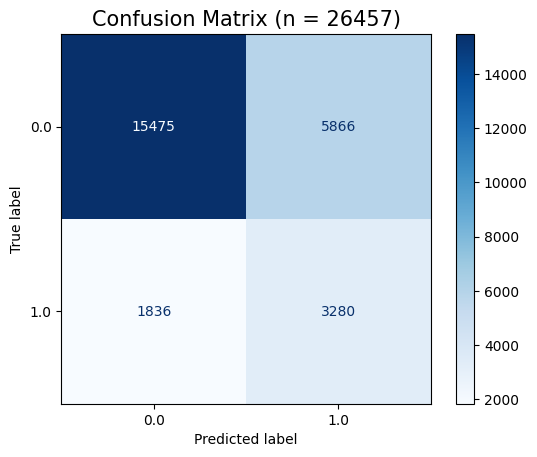

AUC: 0.7525268922426077


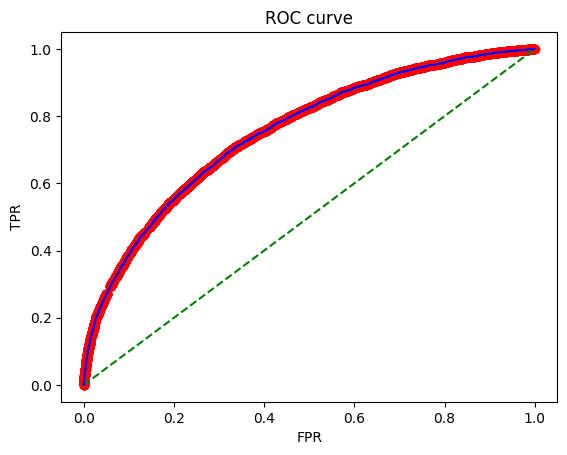

f1 Test score for XGBoost: 0.4599635394755294
f1 Training score for XGBoost: 0.49975348640653616


In [61]:
print(classification_report(y_test, xgb_pipe.predict(X_test)))

plot_confusion_matrix(xgb_pipe, X_test, y_test, cmap=plt.cm.Blues)
log_mat = confusion_matrix(y_test, xgb_pipe.predict(X_test))
#sns.heatmap(log_mat, annot=True,fmt="g",cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix (n = {len(y_test)})", fontsize=15)
plt.show()

y_pred_proba = xgb_pipe.predict_proba(X_test)[:, 1]
print("AUC:", roc_auc_score(y_test, y_pred_proba))

baseline_fpr, baseline_tpr, _ = roc_curve(y_test, [0] * len(y_test))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot(baseline_fpr, baseline_tpr, linestyle="--", color="green", label="Baseline")
plt.plot(fpr, tpr, color="blue", label="Model")
plt.scatter(fpr, tpr, color="red")
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

print(f"f1 Test score for XGBoost: {f1_score(y_test, xgb_pipe.predict(X_test))}")
print(f"f1 Training score for XGBoost: {f1_score(y_train, xgb_pipe.predict(X_train))}")